## PCA to Autoencoders
##### EECS 495: Optimization for Machine Learning and Deep Learning, Final Project
##### By Philip Meyers IV (pmm432)

For my final project, I wanted to look at the spectrum of solutions to problems of dimensionality reduction and reconstruction. As we learned in class, one can take a linear approach to dimensionality reduction via PCA. Given some points $\textbf{x}$ in dimension $N$, PCA attempts to find a coding $\textbf{C}$ in dimension $K<N$ and embedding $\textbf{w}$ such that $\textbf{C} \textbf{w} \approx \textbf{x}$. PCA is a great option because each step in the optimization problem to find such $\textbf{C}, \textbf{w}$ has closed form solutions. PCA is hence relatively quick to compute, does not have many tunable hyperparameters, and converges quickly. The following is an implementation of PCA:

In [44]:
import numpy as np
import matplotlib.pyplot as plt
# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline

from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib inline
%reload_ext autoreload

In [45]:
# PCA Implementation
def PCA(X, num_dims, iterations):
    C_init = np.eye(X.shape[0], num_dims)
    W_init = np.random.normal(size=(num_dims, X.shape[1]))
    return _PCA_optimizer(X, C_init, W_init, iterations)

def _PCA_optimizer(X, C, W, iterations):
    error = []
    for i in range(iterations):
        # Update W
        W = np.dot(np.dot(np.linalg.pinv(np.dot(C.T, C)), C.T), X)
            
        # Update C
        C = np.dot(np.dot(X,W.T), np.linalg.pinv(np.dot(W,W.T)))
        error.append(sre(X,C,W))
        
    return C, W, error

def sre(X, C, W):
    proj = np.dot(C,W)
    sre = np.sum(np.linalg.norm(X - proj, axis=1))
    return sre

To test it out, let's generate some data and see how well PCA can reduce and reconstruct the data from 2 dimensions (the identity function) and 1 dimension:

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


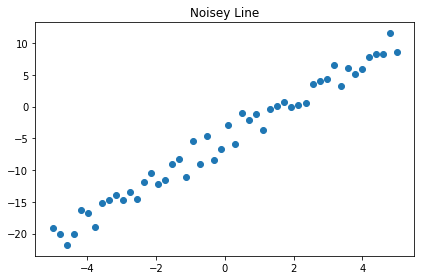

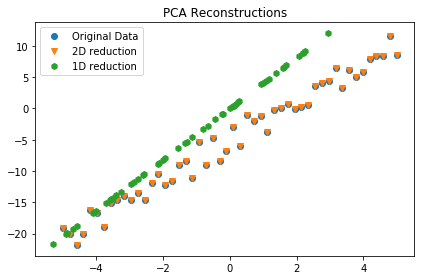

In [46]:
X = np.linspace(-5,5,50)
Y = (3*X) - 5 + 2*np.random.normal(size=50)
data = np.vstack([X,Y])
fig, ax = plt.subplots()
plt.plot(data[0,:], data[1,:], 'o')
plt.title('Noisey Line')
plt.show()

iterations = 1000
C_2,W_2,error_2 = PCA(data, 2, iterations)
proj_2 = np.dot(C_2,W_2)

C_1,W_1,error_1 = PCA(data, 1, iterations)
proj_1 = np.dot(C_1,W_1)

fig, ax = plt.subplots()
plt.title('PCA Reconstructions')
plt.plot(data[0,:], data[1,:], 'o', label='Original Data')
plt.plot(proj_2[0,:], proj_2[1,:], 'v', label='2D reduction')
plt.plot(proj_1[0,:], proj_1[1,:], 'h', label='1D reduction')
plt.legend(loc='best')
plt.show()

After just 1000 iterations, PCA learns both the identity and reduction to 1 dimension quite well. We can visualize these learning processes by looking at the squared reconstruction errors:

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


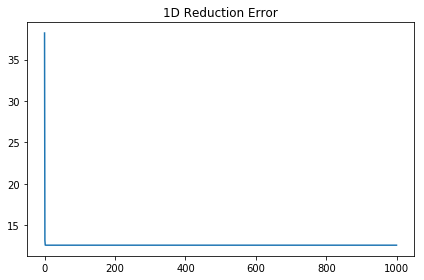

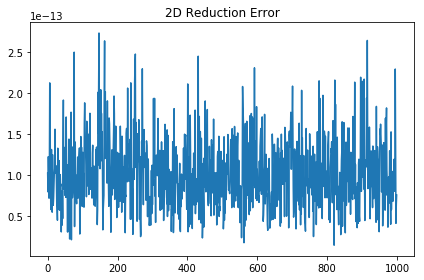

In [47]:
def plot_error(error, title):
    fig, ax = plt.subplots()
    x = range(len(error))
    y = error
    plt.plot(x, y)
    plt.title(title)
    plt.show()

plot_error(error_1, '1D Reduction Error')
plot_error(error_2, '2D Reduction Error')

Although we already have an efficient way of optimizing the coding and embeddings for PCA, we can also find optimal values via backpropagation. Rather than using closed form solutions to update $\textbf{C}$ and $\textbf{w}$, we can perform gradient descent on the reconstruction error with respect to $\textbf{C}$ and $\textbf{w}$. Here we are using Tensorflow to efficiently represent the computation graph and for ease of optimization:

In [48]:
import tensorflow as tf
# PCA via Backprop
def PCA_backprop(data, num_components, iterations, epsilon):
    num_points, num_dims = data.shape
    X = tf.placeholder("float", [None, num_dims])
    
    code = tf.Variable(tf.random_uniform([num_dims, num_components]))
    h = tf.matmul(X, code)
    Y = tf.matmul(h,tf.transpose(code))
                       
    mse = tf.reduce_mean(tf.square(X - Y))
    train_step = tf.train.GradientDescentOptimizer(epsilon).minimize(mse)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        error = []
        for i in range(iterations):
            sess.run(train_step, feed_dict={X: data})
            error.append(sess.run(mse, feed_dict={X:data}))

        C = sess.run(code, feed_dict={X:data})
        W = sess.run(h, feed_dict={X:data})
        
        return C,W.T, error

Although the method of optimization is different, the underlying problem is the same so it should be no suprise that PCA's learned via backprop are almost identical to the ones above.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


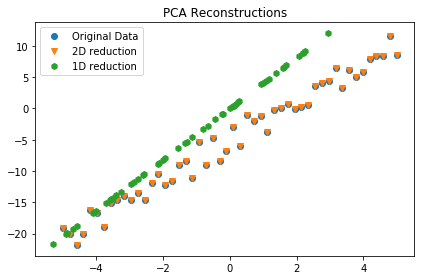

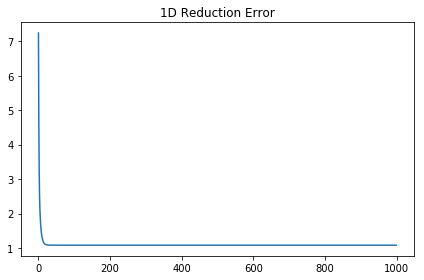

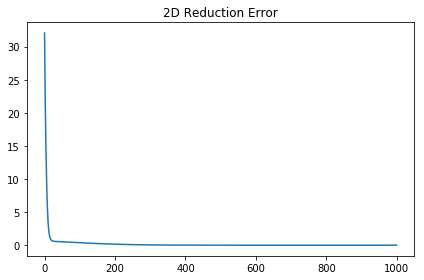

In [49]:
C_2,W_2,error_2 = PCA_backprop(data.T, 2, iterations, 10e-4)
proj_2 = np.dot(C_2,W_2)

C_1,W_1,error_1 = PCA_backprop(data.T, 1, iterations, 10e-4)
proj_1 = np.dot(C_1,W_1)

fig, ax = plt.subplots()
plt.title('PCA Reconstructions')
plt.plot(data[0,:], data[1,:], 'o', label='Original Data')
plt.plot(proj_2[0,:], proj_2[1,:], 'v', label='2D reduction')
plt.plot(proj_1[0,:], proj_1[1,:], 'h', label='1D reduction')
plt.legend(loc='best')
plt.show()

plot_error(error_1, '1D Reduction Error')
plot_error(error_2, '2D Reduction Error')

In both examples (really just two versions of the same example), PCA worked quite well because the underlying function was also linear. However, when the function is non-linear, we get much different results. The 2D PCA still works great because it is only learning the identity function. However, the reconstruction from the 1D reduction looks nothing like the original quadratic.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


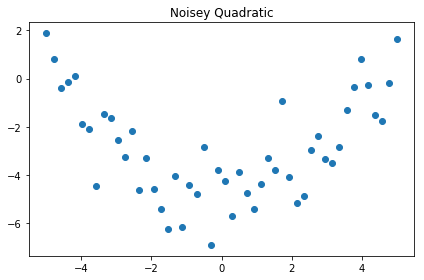

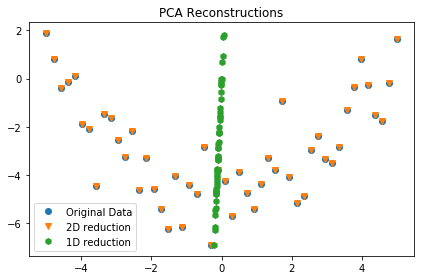

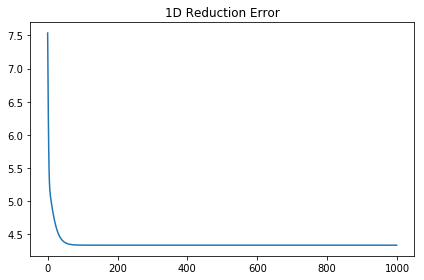

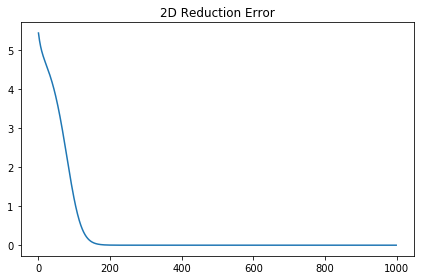

In [50]:
X = np.linspace(-5,5,50)
Y_nn = (.25*X**2) - 5
Y = Y_nn +  + np.random.normal(size=50)
data = np.vstack([X,Y])
fig, ax = plt.subplots()
plt.plot(data[0,:], data[1,:], 'o')
plt.title('Noisey Quadratic')
plt.show()

C_2,W_2,error_2 = PCA_backprop(data.T, 2, iterations, 10e-4)
proj_2 = np.dot(C_2,W_2)

C_1,W_1,error_1 = PCA_backprop(data.T, 1, iterations, 10e-3)
proj_1 = np.dot(C_1,W_1)

fig, ax = plt.subplots()
plt.title('PCA Reconstructions')
plt.plot(data[0,:], data[1,:], 'o', label='Original Data')
plt.plot(proj_2[0,:], proj_2[1,:], 'v', label='2D reduction')
plt.plot(proj_1[0,:], proj_1[1,:], 'h', label='1D reduction')
plt.legend(loc='best')
plt.show()

plot_error(error_1, '1D Reduction Error')
plot_error(error_2, '2D Reduction Error')

Clearly we need some kind of non-linearity in order to better learn a lower dimensional embedding of a non-linear function. Such non-linearity can be easily achieved by slightly modifying our PCA backprop code. By adding a tanh activation function (and biases) to the embedding, we are immediately given non-linearity abilities. The following is a shallow autoencoder:

In [51]:
def autoencoder_shallow(data, num_components, iterations, epsilon):
    num_points, num_dims = data.shape

    # Input layer 
    x = tf.placeholder("float", [None, num_dims])
    
    # Encoding Layer     
    W_encoder = tf.Variable(tf.random_uniform([num_dims, num_components]))
    b_encoder = tf.Variable(tf.random_uniform([num_components]))
    encoder = tf.nn.tanh(tf.matmul(tf.cast(data, tf.float32), W_encoder) + b_encoder)
    
    # Decoding Layer
    W_decoder = tf.transpose(W_encoder) # Using same code matrix
    b_decoder = tf.Variable(tf.random_uniform([num_dims]),dtype=tf.float32)
    decoder = tf.nn.tanh(tf.matmul(encoder, W_decoder) + b_decoder)
    
    mse = tf.reduce_mean(tf.square(x - decoder))
    train_step = tf.train.GradientDescentOptimizer(epsilon).minimize(mse)
    
    
    error = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(iterations):
            sess.run(train_step, feed_dict={x: data})
            error.append(sess.run(mse, feed_dict={x:data}))

        encodings = sess.run(encoder, feed_dict={x:data}).T
        reconstructions = sess.run(decoder, feed_dict={x:data}).T

        return reconstructions, encodings, error



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


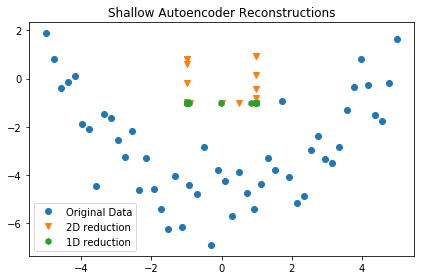

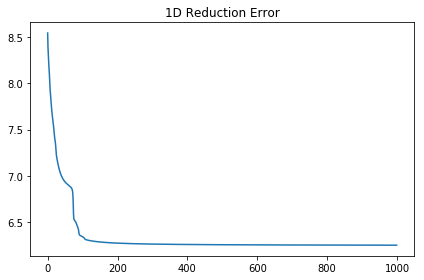

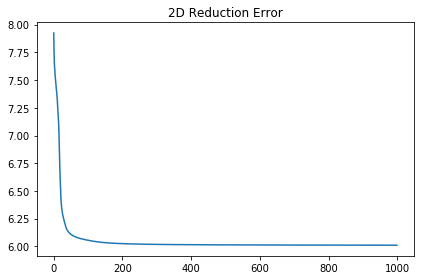

In [52]:
recons_2, encodings_2, error_2 = autoencoder_shallow(data.T, 2, 1000, 10e-2)
recons_1, encodings_1, error_1 = autoencoder_shallow(data.T, 1, 1000, 10e-2)

fig, ax = plt.subplots()
plt.title('Shallow Autoencoder Reconstructions')
plt.plot(data[0,:], data[1,:], 'o', label='Original Data')
plt.plot(recons_2[0,:], recons_2[1,:], 'v', label='2D reduction')
plt.plot(recons_1[0,:], recons_1[1,:], 'h', label='1D reduction')
plt.legend(loc='best')
plt.show()

plot_error(error_1, '1D Reduction Error')
plot_error(error_2, '2D Reduction Error')

At first glance, the results of the shallow autoencoder are disappointing. Neither reconstruction of points is seems to be anywhere near where they should be. Step size and training time also do not seem to be the problem since the errors both seem to decrease monotonically and bottom out. On closer inspection, it appears that all of the points fall into a rectangle bounded by plus/minus 1 on all sides. This is exactly the range of the tanh function! Since the tanh function cannot map anything outside of (-1,1), we need to first scale the data to (-1,1), find a non-linear embedding, and then re-scale the reconstructed data back to its original scale. The modified function autoencoder_shallow_normed does exactly that:

In [53]:
def autoencoder_shallow_normed(data, num_components, iterations, epsilon):
    num_points, num_dims = data.shape

    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    
    scale = lambda d: (d - data_min) / (data_max - data_min)
    unscale = lambda d: d * (data_max - data_min) + data_min
    
    data_scale = scale(data)
    # Input layer 
    x = tf.placeholder("float", [None, num_dims])
    
    # Encoding Layer     
    W_encoder = tf.Variable(tf.random_uniform([num_dims, num_components]))
    b_encoder = tf.Variable(tf.random_uniform([num_components]))
    encoder = tf.nn.tanh(tf.matmul(tf.cast(data, tf.float32), W_encoder) + b_encoder)
    
    # Decoding Layer
    W_decoder = tf.transpose(W_encoder) # Using same code matrix
    b_decoder = tf.Variable(tf.random_uniform([num_dims]),dtype=tf.float32)
    decoder = tf.nn.tanh(tf.matmul(encoder, W_decoder) + b_decoder)
    
    mse = tf.reduce_mean(tf.square(x - decoder))
    train_step = tf.train.GradientDescentOptimizer(epsilon).minimize(mse)
    
    error = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        error = []
        for i in range(iterations):
            _, loss = sess.run([train_step, mse], feed_dict={x: data_scale})
            error.append(loss)
        
        reconstructions = unscale(sess.run(decoder, feed_dict={x:scale(data_scale)})).T
        encodings = sess.run(encoder, feed_dict={x:scale(data_scale)}).T
        return reconstructions, encodings, error

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


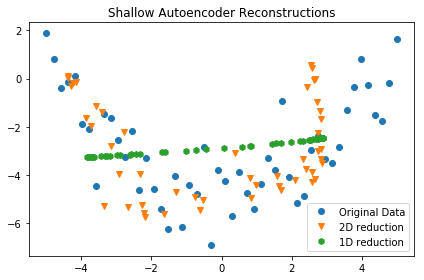

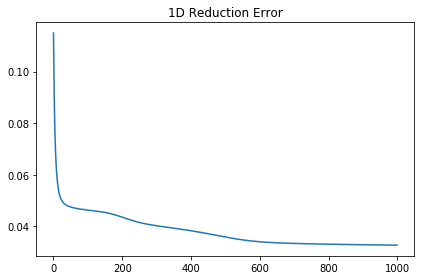

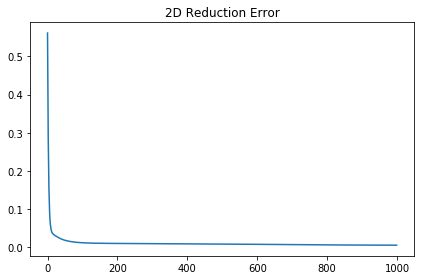

In [54]:
recons_2, encodings_2, error_2 = autoencoder_shallow_normed(data.T, 2, 1000, 10e-2)
recons_1, encodings_1, error_1 = autoencoder_shallow_normed(data.T, 1, 1000, 10e-2)

fig, ax = plt.subplots()
plt.title('Shallow Autoencoder Reconstructions')
plt.plot(data[0,:], data[1,:], 'o', label='Original Data')
plt.plot(recons_2[0,:], recons_2[1,:], 'v', label='2D reduction')
plt.plot(recons_1[0,:], recons_1[1,:], 'h', label='1D reduction')
plt.legend(loc='best')
plt.show()

plot_error(error_1, '1D Reduction Error')
plot_error(error_2, '2D Reduction Error')

The results look a little better, but still leave much to be desired. We can try to increase the number of training iterations and the learning rate to get better results. Or we can take a different route: increase the non-linearity-ness. autoencoder_deep_normed adds a second non-linear layer that can hopefully capture a great range of non-linear spaces.

In [55]:
def autoencoder_deep_normed(data, components, iterations, epsilon):
    num_points, num_dims = data.shape
    
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    
    scale = lambda d: (d - data_min) / (data_max - data_min)
    unscale = lambda d: d * (data_max - data_min) + data_min
    
    data_scale = scale(data)
    # Input layer 
    x = tf.placeholder("float", [None, num_dims])
    
    # Encoding Layer     
    W_encoder1 = tf.Variable(tf.random_uniform([num_dims, components[0]]))
    b_encoder1 = tf.Variable(tf.random_uniform([components[0]]))
    encoder1 = tf.nn.tanh(tf.matmul(tf.cast(data, tf.float32), W_encoder1) + b_encoder1)
    
    W_encoder2 = tf.Variable(tf.random_uniform([components[0], components[1]]))
    b_encoder2 = tf.Variable(tf.random_uniform([components[1]]))
    encoder2 = tf.nn.tanh(tf.matmul(encoder1, W_encoder2) + b_encoder2)
    
    # Decoding Layer
    W_decoder2 = tf.transpose(W_encoder2) # Using same code matrix
    b_decoder2 = tf.Variable(tf.random_uniform([components[0]]))
    decoder2 = tf.nn.tanh(tf.matmul(encoder2, W_decoder2) + b_decoder2)
    
    W_decoder1 = tf.transpose(W_encoder1) # Using same code matrix
    b_decoder1 = tf.Variable(tf.random_uniform([num_dims]))
    decoder1 = tf.nn.tanh(tf.matmul(decoder2, W_decoder1) + b_decoder1)
    
    mse = tf.reduce_mean(tf.square(x - decoder1))
    train_step = tf.train.GradientDescentOptimizer(epsilon).minimize(mse)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        error = []
        for i in range(iterations):
            sess.run(train_step, feed_dict={x: data_scale})
            error.append(sess.run(mse, feed_dict={x:data_scale}))

        reconstructions = unscale(sess.run(decoder1, feed_dict={x:scale(data_scale)})).T
        encodings = sess.run(encoder2, feed_dict={x:scale(data_scale)}).T
        return reconstructions, encodings, error

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


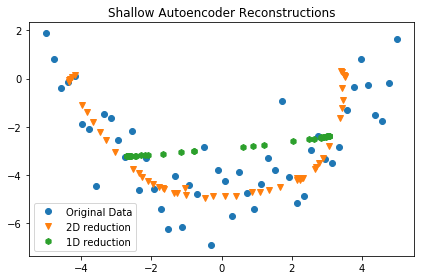

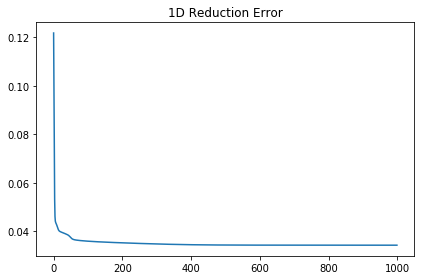

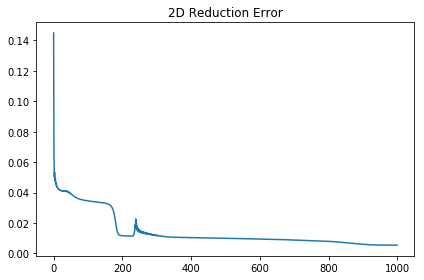

In [56]:
recons_2, encodings_2, error_2 = autoencoder_deep_normed(data.T, [2,2], 1000, 10e-1)
recons_1, encodings_1, error_1 = autoencoder_deep_normed(data.T, [1,1], 1000, 10e-1)

fig, ax = plt.subplots()
plt.title('Shallow Autoencoder Reconstructions')
plt.plot(data[0,:], data[1,:], 'o', label='Original Data')
plt.plot(recons_2[0,:], recons_2[1,:], 'v', label='2D reduction')
plt.plot(recons_1[0,:], recons_1[1,:], 'h', label='1D reduction')
plt.legend(loc='best')
plt.show()

plot_error(error_1, '1D Reduction Error')
plot_error(error_2, '2D Reduction Error')

The 1D reduction is a little better, but the far more interesting result is the 2D reduction. Rather than learning the identity function for the noisy points, the autoencoder performing a 2D reduction appears to have reconstructed something that looks like the original quadratic. Let's verify this visually:

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


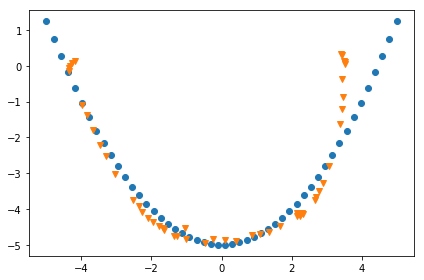

In [57]:
fig, ax = plt.subplots()
plt.plot(X, Y_nn, 'o')
plt.plot(recons_2[0,:], recons_2[1,:], 'v', label='2D reduction')
plt.show()

The orange reconstructions appear to pretty closely map to the original blue quadratic function. In essence, the 2D autoencoder took in noisy input and return a de-noised version of it! We could try to further increase the non-linearity of the deep autoencoder by adding more layers, but we risk overfitting to the data and learning an identity function for the noisy function, rather than for the true, underlying function.

Another visualization of dimensionality reduction is on an image. An image is composed of 3D pixels of (R,G,B) values. It would be convenient and more space efficient (especially on large images) if we could embed the pixels of an image into a smaller 2D space and still (somewhat) accurately recreate the image. Let's see how PCA, a shallow autoencoder, and a deep autoencoder perform on this task:

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  app.launch_new_instance()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


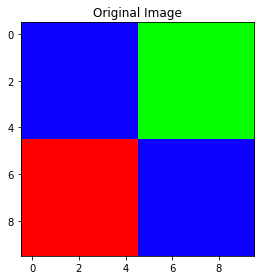

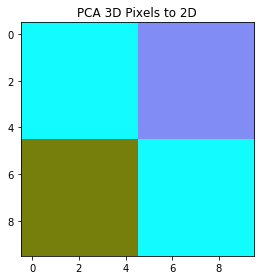

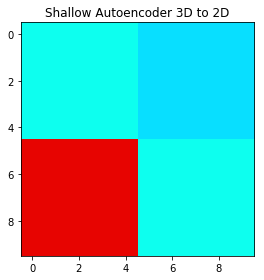

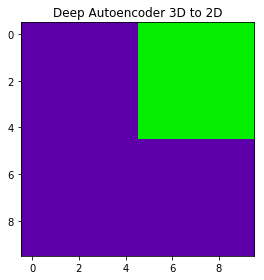

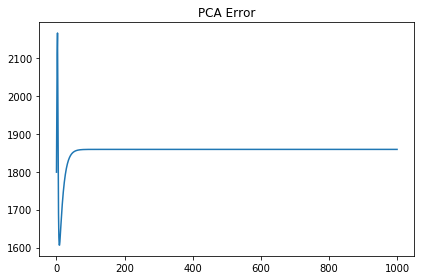

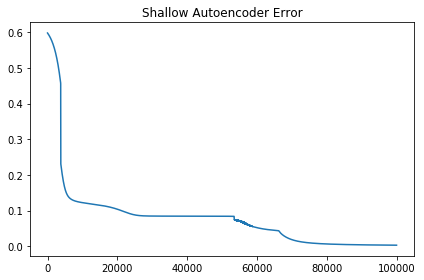

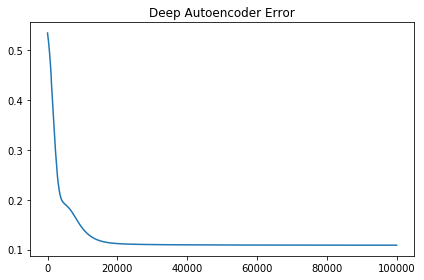

In [58]:
from scipy.ndimage import imread
from matplotlib.pyplot import imshow
squares = imread('color.png')
plt.figure()
plt.title('Original Image')
plt.imshow(squares)

pixels = np.reshape(squares, (-1, 3)).T
C,W,error = PCA(pixels, 2, 1000)
proj = np.dot(C,W)
recovered_image = np.reshape(proj.T, squares.shape).astype('uint8')
plt.figure()
plt.title('PCA 3D Pixels to 2D')
plt.imshow(recovered_image)

ae_s_recons, ae_s_encodings, ae_s_error = autoencoder_shallow_normed(pixels.T, 2, 100000, 10e-4)
ae_s_image = np.reshape(ae_s_recons.T, squares.shape).astype('uint8')
plt.figure()
plt.title('Shallow Autoencoder 3D to 2D')
plt.imshow(ae_s_image)

ae_d_recons, ae_d_encodings, ae_d_error = autoencoder_deep_normed(pixels.T, [3,2], 100000, 10e-4)
ae_d_image = np.reshape(ae_d_recons.T, squares.shape).astype('uint8')
plt.figure()
plt.title('Deep Autoencoder 3D to 2D')
plt.imshow(ae_d_image)

plot_error(error, 'PCA Error')
plot_error(ae_s_error, 'Shallow Autoencoder Error')
plot_error(ae_d_error, 'Deep Autoencoder Error')

While PCA and the shallow autoencoder preserved the edges and color similarities of the smaller squares (in that the top right and bottom left are the same color), they squares still aren't the *correct* color.

One possible explanation for why PCA and the shallow autoencoder to some extent fail to reconstruct colors that appear similar to the original ones is that the error being minimized is the Eucledian distance between the original pixel value and the reconstructed value. The Eucledian distance between two 3D pixels is not necessarily indicative of the human percieved similarity of the two colors the pixels represent. Perhaps better quality images could be reconstructed from PCA and the shallow autoencoder if the error function did not penalize Eucledian distance, rather some measure of human percieved color dissimilarity.